# LSTM

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional, GlobalAveragePooling1D, Dropout, SpatialDropout1D,BatchNormalization, Dropout
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

df_tweets = pd.read_csv("tweets-clean.csv", sep=";")

max_words = 15000
max_len = 75
tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
tokenizer.fit_on_texts(df_tweets['clean_content'].values.astype('U'))
X = tokenizer.texts_to_sequences(df_tweets['clean_content'].values.astype('U'))
X = pad_sequences(X, maxlen=max_len)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_tweets['polarity'])
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz
!gunzip cc.id.300.vec.gz

embeddings_index = {}
with open('cc.id.300.vec', encoding='utf-8') as f:
    next(f)  
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

embedding_dim = 300   
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
embedding_dim = 300
model = Sequential()
model.add(Embedding(
    input_dim=num_words,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_len,
    trainable=True   
))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

import tensorflow as tf

def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        pt = tf.reduce_sum(y_true * y_pred, axis=-1)
        return alpha * tf.pow(1. - pt, gamma) * ce
    return loss

model.compile(loss=focal_loss(), optimizer='adam', metrics=['accuracy'])

model.summary()

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint_callback = ModelCheckpoint('best_model.weights.h5', save_weights_only=True, monitor='val_loss', save_best_only=True)

batch_size = 64
epochs = 10
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping_callback, model_checkpoint_callback])

from tensorflow.keras.models import load_model

num_words = min(max_words, len(word_index) + 1)

embedding_dim = 300
loaded_model = Sequential()
loaded_model.add(Embedding(
    input_dim=num_words,        
    output_dim=embedding_dim,   
    weights=[embedding_matrix],
    input_length=max_len,
    trainable=False
))

loaded_model.add(SpatialDropout1D(0.2))
loaded_model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
loaded_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
loaded_model.add(Dropout(0.5))
loaded_model.add(BatchNormalization())
loaded_model.add(Dense(3, activation='softmax'))
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
loaded_model.build((None, max_len))  
loaded_model.load_weights('best_model.weights.h5')

y_pred = loaded_model.predict(X_test, batch_size=batch_size, verbose=1)
y_pred_classes = y_pred.argmax(axis=-1)
y_true = y_test.argmax(axis=-1)

print("Accuracy:", accuracy_score(y_true, y_pred_classes))
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))



--2025-12-10 02:38:15--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.68, 3.171.22.13, 3.171.22.118, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1227018698 (1.1G) [binary/octet-stream]
Saving to: ‘cc.id.300.vec.gz’

cc.id.300.vec.gz    100%[===================>]   1.14G  20.7MB/s    in 42s     

2025-12-10 02:38:57 (28.2 MB/s) - ‘cc.id.300.vec.gz’ saved [1227018698/1227018698]

Found 2000000 word vectors.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │     2,307,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_4             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,307,000 (8.80 MB)

 Trainable params: 2,307,000 (8.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 343ms/step - accuracy: 0.3869 - loss: 0.1896 - val_accuracy: 0.4340 - val_loss: 0.1176
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 286ms/step - accuracy: 0.4696 - loss: 0.1348 - val_accuracy: 0.4340 - val_loss: 0.1168
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 306ms/step - accuracy: 0.5620 - loss: 0.1058 - val_accuracy: 0.4340 - val_loss: 0.1154
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 304ms/step - accuracy: 0.5843 - loss: 0.0958 - val_accuracy: 0.4438 - val_loss: 0.1142
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 222ms/step - accuracy: 0.6651 - loss: 0.0796 - val_accuracy: 0.4707 - val_loss: 0.1104
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 261ms/step - accuracy: 0.7448 - loss: 0.0656 - val_accuracy: 0.5196 - val_loss: 0.1067
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 284ms/step - accuracy: 0.7985 - loss: 0.0520 - val_accuracy: 0.5966 - val_loss: 0.1022
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 283ms/step - accuracy: 0.8718 - loss: 0.0376 - val_accuracy:

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step
Accuracy: 0.6063569682151589
              precision    recall  f1-score   support

    negative       0.70      0.71      0.71       355
     neutral       0.50      0.62      0.56       266
    positive       0.60      0.41      0.48       197

    accuracy                           0.61       818
   macro avg       0.60      0.58      0.58       818
weighted avg       0.61      0.61      0.60       818



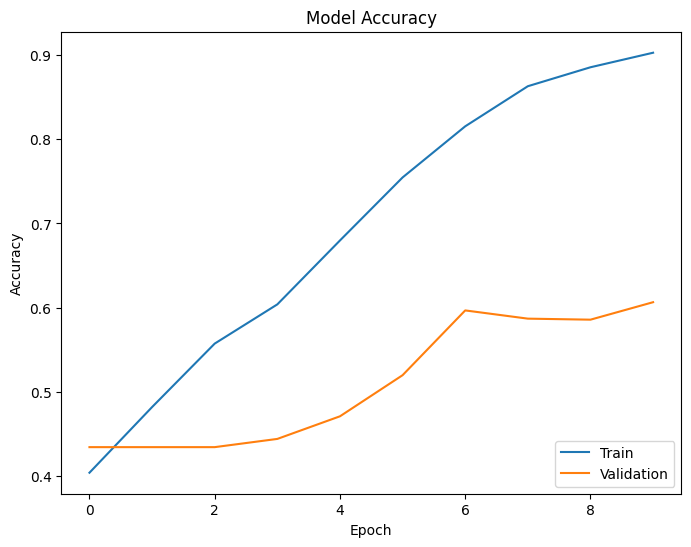

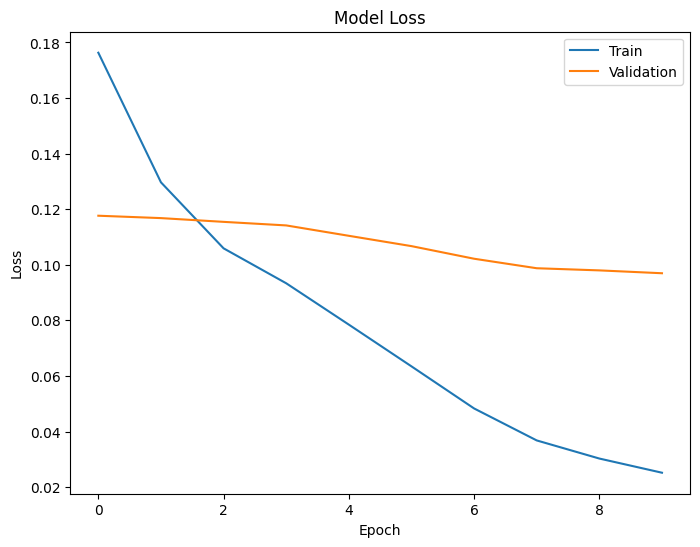

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
pred = model.predict(X_test)
print(pred[:5])


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step
[[0.228905   0.30148253 0.46961245]
 [0.19355974 0.5274692  0.27897108]
 [0.22824588 0.43370306 0.33805093]
 [0.09878745 0.5592796  0.3419329 ]
 [0.28735337 0.23879765 0.47384897]]



=== Sentiment Distribution (Predicted) ===
positive: 133 (16.26%)
neutral: 328 (40.10%)
negative: 357 (43.64%)


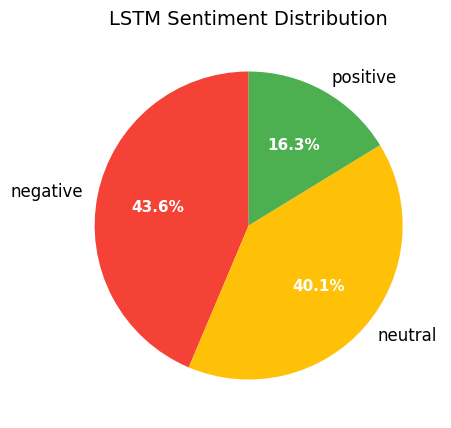

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

pred_labels = label_encoder.inverse_transform(y_pred_classes)
cnt = Counter(pred_labels)
total = len(pred_labels)

print("\n=== Sentiment Distribution (Predicted) ===")
for label, count in cnt.items():
    print(f"{label}: {count} ({count/total:.2%})")

df_dist = pd.DataFrame.from_dict(cnt, orient='index', columns=['Count'])
df_dist['Percentage'] = (df_dist['Count'] / total) * 100
df_dist = df_dist.sort_index()  

plt.figure(figsize=(5,5))

def white_autopct(pct):
    return f'{pct:.1f}%' if pct > 0 else ''

color_map = {'negative': '#F44336', 'neutral': '#FFC107', 'positive': '#4CAF50'}
ordered_colors = [color_map[label] for label in df_dist.index]

patches, texts, autotexts = plt.pie(
    df_dist['Count'],
    labels=df_dist.index,
    autopct=white_autopct,
    startangle=90,
    colors=ordered_colors
)

for text in texts:
    text.set_color('black')
    text.set_fontsize(12)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(11)
    autotext.set_fontweight('bold')

plt.title("LSTM Sentiment Distribution", fontsize=14, color='black')
plt.savefig("lstm pie chart", dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get predicted class for each sample (0=negative, 1=neutral, 2=positive)
y_pred_classes = np.argmax(y_pred, axis=1)

# Map numeric labels to text labels
label_map = {0: 'Neutral', 1: 'Positive', 2: 'Negative'}
y_labels = [label_map[i] for i in y_pred_classes]

# Count occurrences of each class
cnt = Counter(y_labels)
total = len(y_labels)

# Convert to DataFrame for easy plotting
df_dist = pd.DataFrame.from_dict(cnt)
df_dist['Percentage'] = (df_dist['Count'] / total) * 100

# Define colors for each sentiment
sentiment_colors = {'Neutral': '#F44336', 'Positive': '#4CAF50', 'Negative': '#FFC107'}

# pie chart
plt.figure(figsize=(5,5))

def white_autopct(pct):
    return f'{pct:.1f}%' if pct > 0 else ''

# Get colors in the order of df_dist index
plot_colors = [sentiment_colors[label] for label in df_dist.index]

patches, texts, autotexts = plt.pie(
    df_dist['Count'],
    labels=df_dist.index,
    autopct=white_autopct,
    startangle=90,
    colors=plot_colors # Use the list of colors here
)

# Set label (category) text color to black
for text in texts:
    text.set_color('black')
    text.set_fontsize(12)

# Set percentage text color to white
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(11)
    autotext.set_fontweight('bold')

plt.title("LSTM Sentiment Distribution", fontsize=14, color='black')
plt.show()

ValueError: If using all scalar values, you must pass an index